## Occlusion Detection

#### Importing Libraries

In [1]:
#%matplotlib inline
import numpy as np 
from matplotlib import pyplot as plt 
import cv2
import imageio
import SimpleITK
import sys
from pylab import *

#### Reading and Visualising the Images 

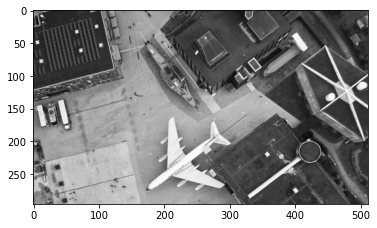

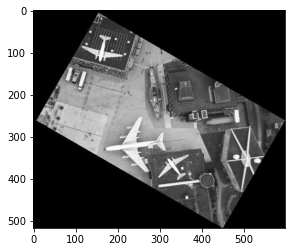

In [2]:
img1=cv2.imread('IMG1.png',0)
img2=cv2.imread('IMG2.png',0)

plt.imshow(img1,cmap='gray')
plt.show()

plt.imshow(img2,cmap='gray')
plt.show()

#### Corresponding Points

In [3]:
points = np.array([[29, 124], [157, 372]])
corresponding_points = np.array([[93, 248], [328, 399]])

#### Bilinear Interpolation

In [4]:
def bilinear_interpolation(src,si,sj):
    #si , sj = src_pt
    #si= ti-ty
    #sj= tj-tx
    si,sj=si+1,sj+1
    i=int(np.floor(si))    
    j=int(np.floor(sj))      ## Here i,j are the co-ordinate points of the top left (t_l)
    t_l = i , j 
    
    ##Now the remaining three co-ordinates with respect to i,j will be 
    t_r = i ,j+1    # Top right
    b_l = i+1 , j   # Bottom Left 
    b_r = i+1 , j+1 # Bottom Right 
    
    ## distance of source point from the top left corner would be 
    di = si - i
    dj = sj - j 
    
    """
    ## Now calculating the pixel value at the source point by using bilinear interpolation technique
    ## Create a variable pxl_val and assign the pixel value obtained by bilinear interpolating pixel values at t_l,t_r,
    ## b_l,b_r
    ## di,dj that we got is used to obtain the weights for interpolation
    ## We ignore all the target points whose source points lies outside the source image.Hence we assign 
    ## these pixel values as 0.
    """
    
    if t_l[0] >= np.shape(src)[0]-1 or t_l[1] >=np.shape(src)[1]-1 or t_l[0]<=0 or t_l[1]<= 0 :
        pxl_val = 0
    else :
        pxl_val = (1-di)*(1-di)*src[t_l] + (1-di)*(dj)*src[t_r] + (di)*(1-dj)*src[b_l]+ (di)*(dj)*src[b_r]
    
    return pxl_val


#### Calculating A matrix and Computing the H matrix

We know from our discussion in class that the solution for h vector
 is the vector corresponding to the smallest singular value of A. From the decomposition mentioned above, this is the last row of V Transpose
 when the singular values are in decreasing order. We then arrange the values appropriately to get the H matrix.

In [5]:
n = len(points)  ## number of corrrespondences 
def homography(corresponding_points,points):
    # from each point correspondance we get two values
    A = np.zeros((2*n, 5))   ## n=len(points)=2 ## A will  be 4 X 5 matrix
    for r in range(n):
        i,j = points[r]
        si,sj = corresponding_points[r]
        # As defined above
        A[2*r] = [si, sj, 1, 0, -i]
        A[2*r+1] = [sj, -si, 0, 1, -j]
    # NumPy SVD gives singular values in decreasing order
    u, s, v_transpose = np.linalg.svd(A)
    # take the last row of v_transpose
    a, b, c, d, h = v_transpose[-1]
    # construct the appropriate 3x3 matrix
    H = np.array([[a, b, c], 
                  [-b, a, d], 
                  [0, 0, h]])
    
    return H    

#### Transforming the image

 Homognous coordinates of the form [a, b, c] can be converted to non homogenous only if c!=0. In case that condition is
 violated, we set the non homogenous coordinates to (0,0) even though
 in reality such a point does not have a finite representation in
 non homogenous coordinates

In [6]:
def transform(src,H):
    r , c = np.shape(src)
    trg = np.zeros((r,c))
    H_inv=np.linalg.inv(H)
    
    ## iterating over the target image and assign all the pixel values to them
    for ti in range(r):
        for tj in range(c):
            # convert to homogenous coordinates
            t= np.array([ti,tj, 1])
            s = H_inv@t
            if s[2]!=0:
                si,sj=s[0]/s[2],s[1]/s[2]
            else:
                si,sj= 0, 0    
            #calculate the corresponding points for (ti,tj) in the source image
            #si,sj are the corresponding points for (ti,tj) 
            #Assign the value using bilinear interpolation
            #Assigniing the intensity values of the target image at (ti,tj) using the bilinear interpolation above
            trg[ti][tj]=bilinear_interpolation(src,si,sj)
    return trg

#### Transformed IMG2

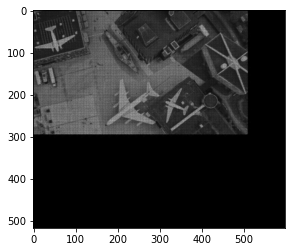

In [7]:
H= homography(corresponding_points,points)
#H = homography(A)
img2_new = transform(img2, H)
plt.imshow(img2_new,cmap='gray')
plt.show()

#### Cropping the transformed image to the  shape of img1

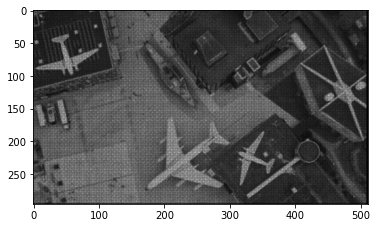

In [8]:
x,y=img1.shape
img2_new_cropped = img2_new[:x, :y]
plt.imshow(img2_new_cropped,cmap='gray')
plt.show()

#### Calculating the difference 

Subtract the aligned transformed img2 and img1 to notice any changes.

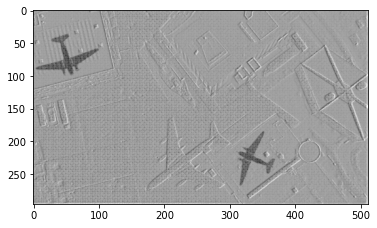

In [9]:
diff=img1-img2_new_cropped
plt.imshow(diff,cmap='gray')
plt.show()